In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import matplotlib.pylab as pl
from itertools import cycle
import matplotlib.gridspec as gridspec
import glob
import collections
import math
import re
import os
from collections import defaultdict

This notebook is used for the species composition analysis of the biofilm threshold theory paper.
Phase2 and phase4 are from the phase diagram in the paper. 

Phase2 = immigration augmented

Phase4 = deterioration limited

In [2]:
nRuns = 100 #reduced to 10 for now to speed things up (nRuns is the no. of files we load into the notebook)
duration = 100.
nSamples = 50

#these durations are used for the second batch of runs, where phase_4 was run for longer to get
#more comparative results for the plots of things vs N_bacteria
duration_phase2 = 100.
nSamples_phase2 = 50
duration_phase4 = 300.
nSamples_phase4 = 150

phase2_filepath = "speciesComp-phase2-fixedImm/geno_distbs"
phase4_filepath = "speciesComp-phase4-fixedImm/geno_distbs"

phase2_bigK_filepath = "speciesComp-phase2-fixedImm-bigK-morePrecise/geno_distbs"
phase4_bigK_filepath = "speciesComp-phase4-fixedImm-bigK-morePrecise/geno_distbs"

In [3]:
def getListOfMeasurementTimes(directory_name):
    '''
    for each runID directory, this gets the filenames and extracts a list of the times they were sampled at.
    directory_name is of form path_to_files/runID_<n>
    
    returns: sorted list of the time vals, in string form with 2 decimal places
    '''
    time_list = []
    def get_numbers_from_filename(filename):
        return re.search(r'(\d+(?:\.\d+)?)', filename).group(0)
    
    for filename in os.listdir(directory_name):
        time_list.append(float(get_numbers_from_filename(filename)))

    return ["{:.2f}".format(float(t)) for t in sorted(time_list)]

In [4]:
def readGenoDistbsFromFile(directoryPath, nRuns):
    '''
    This method reads in the geno distributions for each timestep for each run.
    Inside the geno_distbs directory there are directories for each of the runs, in the form runID_NN.
    Inside each of the runID directories there are several csv files, which contain the geno distributions over the microhabitats for several time samples.
    These geno distributions have the format of each line containing the genotypes present in each microhabitat.
    Each line is a seperate microhabitat, need to "transpose" the dataframe once it's read in.
    
    directoryPath is the path to the geno_distbs directory which contains all the runID directories
    
    Returns: a dictionary where each key is the run_ID, and each entry is another dictionary - 
    The keys in these subdictionaries are the time values, and the entries in these subdictionaries are dataframes with each column being the genotypes in each microhabitat.
    
    This method is an improved version of the earlier one.  This one lists through the times listed in the filenames, doesn't depend on duration or nSamples
    '''
    
    runID_dict = {} #dictionary containing all of the runs, the IDs are the keys
    
    #iterate over all the runs
    for rID in range(nRuns):
        runID_key = "runID_"+str(rID)
        print(runID_key)
        filepath_runID = directoryPath+"/"+runID_key
        time_dict = {} #dictionary containing geno dataframes for each timestep
        
        time_list = getListOfMeasurementTimes(filepath_runID) #sorted list of the times that the genos were sampled at in this run
        
        for t in time_list:
            
            filepath_time = filepath_runID+"/geno_distb-t="+t+".csv"
            
            #need to swap the rows and columns so that the microhabitat is the key in the dataframe
            #geno_df = pd.read_csv(filename, header=None).T
            geno_df = pd.DataFrame([line.strip().split(',') for line in open(filepath_time, 'r')]).T
            #geno
            new_header = geno_df.iloc[0] #grab the first row for the header
            geno_df = geno_df[1:] #take the data less the header row
            geno_df.columns = new_header #set the header row as the df header
            
            geno_df = geno_df.astype(float)
            
            #round the time to the nearest integer value to make reading it in easier
            #the [-3] is so the decimal point and decimal numbers are removed when casting the string to an int
            time_dict[int(t[:-3])] = geno_df
        
        
        runID_dict[runID_key] = time_dict
        
    return runID_dict

In [ ]:
phase4_data = readGenoDistbsFromFile(phase4_bigK_filepath, nRuns)

runID_0
runID_1
runID_2


In [ ]:
phase2_data = readGenoDistbsFromFile(phase2_bigK_filepath, nRuns)

In [34]:
print(phase4_data["runID_2"].keys())

dict_keys([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202])


In [70]:
def shannonIndexAndEquitability(geno_data):
    '''
    rather than use the somewhat convoluted CV(V) method to quantify how the populations' diversities
    changed over time, we will instead use the Shannon index to measure the variance in the population's genotypes.
    
    This method finds the shannon index, H, of each population over time and returns the average of them
    Also does the same for the shannon equitability, E.
    E is defined as H/ln(S), where S is the no. of species.
    
    H is the shannon index, S is the no. of species, E is the shannon equitability
    
    returns: 
    -list of the times that the genotype samples were taken at (used for plotting wrt time)
    -list of the no. of bacteria over time (used for plotting wrt N)
    -list of the shannon index H at each time sample
    -list of the shannon equitability E at each time sample
    -list of the no. of species S at each time sample
    '''
    
    times = []
    nBac_t = defaultdict(list) #no. of bacteria over time
    H_t = defaultdict(list) #shannon index over time
    E_t = defaultdict(list) #shannon equitability over time
    S_t = defaultdict(list) #no. of species over time
    
    for r in range(nRuns):
        run_key = "runID_"+str(r)
        
        times = geno_data[run_key].keys()
        #print(times)
        
        for time_key in times:
            
            #here we create an array with all the genotypes in it and remove any nans
            geno_vals = geno_data[run_key][time_key].values.flatten()[~np.isnan(geno_data[run_key][time_key].values.flatten())]
            nTot = geno_vals.size #total number of bacteria in the population
            genoCounts = collections.Counter(geno_vals) #number of members of each bacterial species in the system
            
            H = sum([-n/nTot*math.log(n/nTot) for _, n in genoCounts.items()]) #shannon index of this run at time t
            S = len(genoCounts.keys()) #no. of different species in the system
            logS_adjusted = 1 if S == 1 else math.log(S)
            E = H/logS_adjusted #shannon equitability
            
            nBac_t[time_key].append(int(nTot))
            H_t[time_key].append(H)
            E_t[time_key].append(E)
            S_t[time_key].append(S)
    
    nBac_t_averaged = [np.mean(np.array(nBac_t[b])) for b in nBac_t.keys()]
    H_t_averaged = [np.mean(np.array(H_t[h])) for h in H_t.keys()]
    E_t_averaged = [np.mean(np.array(E_t[e])) for e in E_t.keys()]
    S_t_averaged = [np.mean(np.array(S_t[s])) for s in S_t.keys()]
    
    return list(H_t.keys()), nBac_t_averaged, H_t_averaged, E_t_averaged, S_t_averaged
        


In [78]:
t_phase2, nBac_vs_t_phase2, H_vs_t_phase2, E_vs_t_phase2, S_vs_t_phase2 = shannonIndexAndEquitability(phase2_data)
t_phase4, nBac_vs_t_phase4, H_vs_t_phase4, E_vs_t_phase4, S_vs_t_phase4 = shannonIndexAndEquitability(phase4_data)

In [ ]:
def plotFigure(x_p2, y_p2, x_p4, y_p4, x_label, y_label, title, filename):
    '''
    method for generic figure plotting to compare the Shannon Index things between the two phases
    '''
    
    plt.figure(figsize=(8,6))

    #miss out the first few values for now becuase they are often much lower than the later ones,
    #skewing the graph.
    #can add them back in if deemed relevant
    plt.plot(x_p2[4:], y_p2[4:], label="phase 2", lw=2.4)
    plt.plot(x_p4[4:], y_p4[4:], label="phase 4", lw=2.4)

    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.title(title, fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=16)
    #plt.savefig("species_comp_plots/"+filename, bbox_inches="tight")
    plt.show()

In [ ]:
plotFigure(t_phase2, H_vs_t_phase2, t_phase4, H_vs_t_phase4, "t", "H", "Shannon Index vs time", "H_vs_t.pdf")

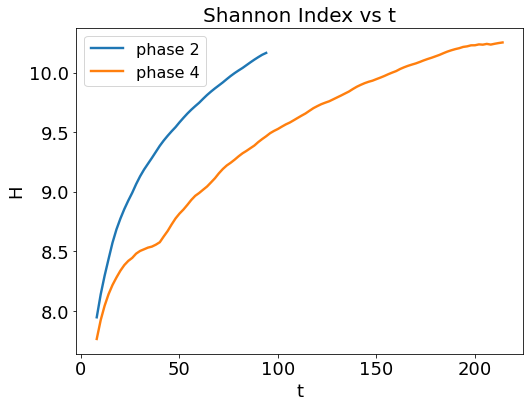

In [81]:
plt.figure(figsize=(8,6))

plt.plot(t_phase2[4:], H_vs_t_phase2[4:], label="phase 2", lw=2.4)
plt.plot(t_phase4[4:], H_vs_t_phase4[4:], label="phase 4", lw=2.4)

plt.xlabel("t", fontsize=18)
plt.ylabel("H", fontsize=18)
plt.title("Shannon Index vs t", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
#plt.savefig("shannon_index_vs_t.pdf", bbox_inches="tight")
plt.show()

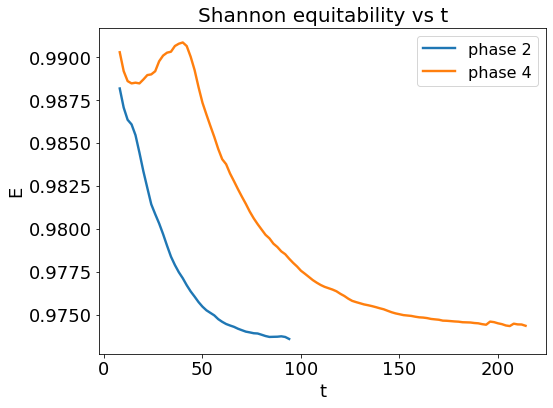

In [75]:
plt.figure(figsize=(8,6))

plt.plot(t_p2[4:], E_t_p2[4:], label="phase 2", lw=2.4)
plt.plot(t_p4[4:], E_t_p4[4:], label="phase 4", lw=2.4)

plt.xlabel("t", fontsize=18)
plt.ylabel("E", fontsize=18)
plt.title("Shannon equitability vs t", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
#plt.savefig("shannon_equitability_vs_t.pdf", bbox_inches="tight")
plt.show()

In [96]:
def shannonIndexAndEquitabilityVsN(geno_data):
        
    '''
    this method calculates the shannon index and shannon equitability vs N for all of the runs, and returns the average value
    shannon equitability is H/ln(S), where S is the no. of species present in the system
    
    args: 
    geno_data - dictionary of dictionaries of dataframes, contains all the genotypes of the bacteria over time, for each run
    
    H is the shannon index, S is the no. of species, E is the shannon equitability
    
    returns: lists of the average values of N (no. of bacteria), H(N), E(N) and S(N)
    '''
    
    #H is the shannon index, S is the no. of species, E is the shannon equitability
    nBac = defaultdict(list)
    H_N = defaultdict(list) #shannon index
    E_N = defaultdict(list) #shannon equitability
    S_N = defaultdict(list) #no. of species
    
    for r in range(nRuns):
        run_key = "runID_"+str(r)
        
        times = geno_data[run_key].keys()
        #print(times)
        
        for time_key in times:
            
            #here we create an array with all the genotypes in it and remove any nans
            geno_vals = geno_data[run_key][time_key].values.flatten()[~np.isnan(geno_data[run_key][time_key].values.flatten())]
            #print(geno_vals)
            nTot = geno_vals.size #total number of bacteria in the population
            genoCounts = collections.Counter(geno_vals) #number of members of each bacterial species in the system
            
            H = sum([-n/nTot*math.log(n/nTot) for _, n in genoCounts.items()]) #shannon index of this run at time t
            S = len(genoCounts.keys()) #no. of different species in the system
            logS_adjusted = max(1, math.log(S))
            E = H/logS_adjusted #shannon equitability
            
            nBac[time_key].append(int(nTot))
            H_N[time_key].append(H)
            E_N[time_key].append(E)
            S_N[time_key].append(S)
    
    nBac_averaged = [np.mean(np.array(nBac[b])) for b in nBac.keys()]
    H_N_averaged = [np.mean(np.array(H_N[h])) for h in H_N.keys()]
    E_N_averaged = [np.mean(np.array(E_N[e])) for e in E_N.keys()]
    S_N_averaged = [np.mean(np.array(S_N[s])) for s in S_N.keys()]
    
    return nBac_averaged, H_N_averaged, E_N_averaged, S_N_averaged

In [97]:
nBac_phase2, H_vs_N_phase2, E_vs_N_phase2, S_vs_N_phase2 = shannonIndexAndEquitabilityVsN(phase2_data)
nBac_phase4, H_vs_N_phase4, E_vs_N_phase4, S_vs_N_phase4 = shannonIndexAndEquitabilityVsN(phase4_data)

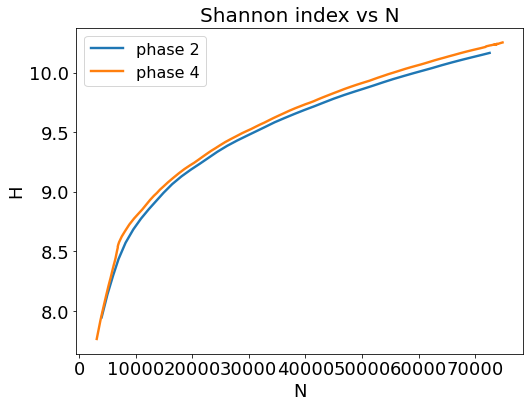

In [102]:
plt.figure(figsize=(8,6))

plt.plot(nBac_phase2[4:], H_vs_N_phase2[4:], label="phase 2", lw=2.4)
plt.plot(nBac_phase4[4:], H_vs_N_phase4[4:], label="phase 4", lw=2.4)

plt.xlabel("N", fontsize=18)
plt.ylabel("H", fontsize=18)
plt.title("Shannon index vs N", fontsize=20)
#plt.semilogy()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
#plt.savefig("shannon_index.pdf", bbox_inches="tight")
plt.show()

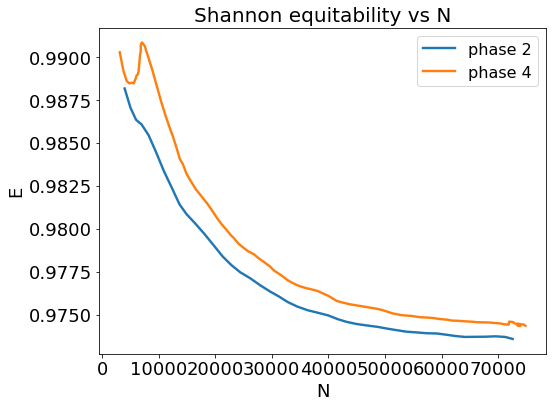

In [93]:
plt.figure(figsize=(8,6))

plt.plot(nBac_phase2[4:], E_vs_N_phase2[4:], label="phase 2", lw=2.4)
plt.plot(nBac_phase4[4:], E_vs_N_phase4[4:], label="phase 4", lw=2.4)

plt.xlabel("N", fontsize=18)
plt.ylabel("E", fontsize=18)
plt.title("Shannon equitability vs N", fontsize=20)
#plt.semilogy()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
#plt.savefig("shannon_index.pdf", bbox_inches="tight")
plt.show()

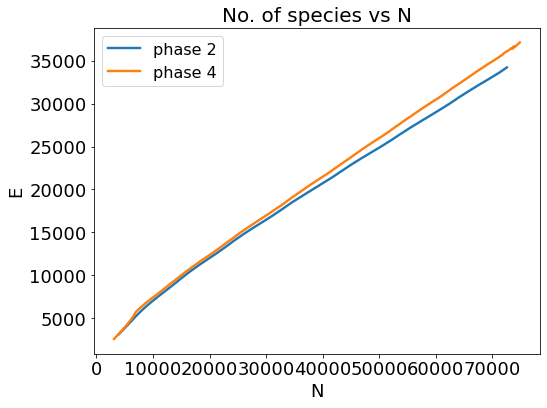

In [98]:
plt.figure(figsize=(8,6))

plt.plot(nBac_phase2[4:], S_vs_N_phase2[4:], label="phase 2", lw=2.4)
plt.plot(nBac_phase4[4:], S_vs_N_phase4[4:], label="phase 4", lw=2.4)

plt.xlabel("N", fontsize=18)
plt.ylabel("S", fontsize=18)
plt.title("No. of species vs N", fontsize=20)
#plt.semilogy()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
#plt.savefig("shannon_index.pdf", bbox_inches="tight")
plt.show()

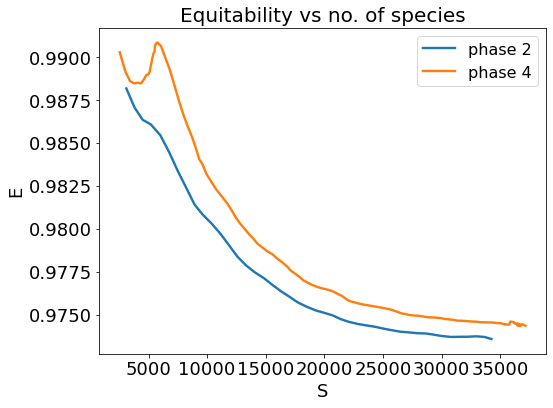

In [101]:
plt.figure(figsize=(8,6))

plt.plot(S_vs_N_phase2[4:], E_vs_N_phase2[4:], label="phase 2", lw=2.4)
plt.plot(S_vs_N_phase4[4:], E_vs_N_phase4[4:], label="phase 4", lw=2.4)

plt.xlabel("S", fontsize=18)
plt.ylabel("E", fontsize=18)
plt.title("Equitability vs no. of species", fontsize=20)
#plt.semilogy()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
#plt.savefig("shannon_index.pdf", bbox_inches="tight")
plt.show()